In [41]:
import pandas as pd
import numpy as np
import os
import json
import jsonlines
import plotly.graph_objects as go
import soccerfield
from utils import *
from voronoi_mod import *
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model_1_data = pd.read_csv('model_1/model_1_data.csv')

In [3]:
model_1_data.columns

Index(['sk_match_id', 'frame', 'minute', 'player_name', 'pass_recipient_name',
       'pass_recipient_id', 'pass_recipient_position', 'sk_player_id',
       'pass_angle', 'type_primary', 'type_secondary', 'location_x',
       'location_y', 'pass_accurate', 'team_name', 'possession_team_name',
       'possession_team_name_src', 'possession_types', 'period',
       'receive_frame', 'receive_x', 'receive_y', 'target_area', 'ball_x_0',
       'ball_y_0', 'ball_x_1', 'ball_y_1', 'player_1', 'ball_x_2', 'ball_y_2',
       'player_2', 'ball_x_3', 'ball_y_3', 'player_3', 'player_0',
       'sk_recipient_id', 'long_name', 'dist_0', 'dist_1', 'dist_2', 'dist_3',
       'score_1', 'score_2', 'score_3', 'attack_score', 'defend_score', 'SoF',
       'attacker_count', 'defender_count', 'combined_score'],
      dtype='object')

In [10]:
match_id = 1133199
file_path = f'data/FA/tracking/{match_id}.jsonl'
data = load_jsonl_file(file_path)
pitch_length, pitch_width = find_pitch_size(match_id)
file_path = f'data/FA/match/{match_id}.json'
match_data = load_json_file(file_path)  
home_id = match_data['home_team']['id']
away_id = match_data['away_team']['id']

home_p_ids = [p['id'] for p in match_data['players'] if p['team_id'] == home_id]
away_p_ids = [p['id'] for p in match_data['players'] if p['team_id'] == away_id]  

In [28]:
pitch_length, pitch_width

(103, 67)

13598.0
315 190 320


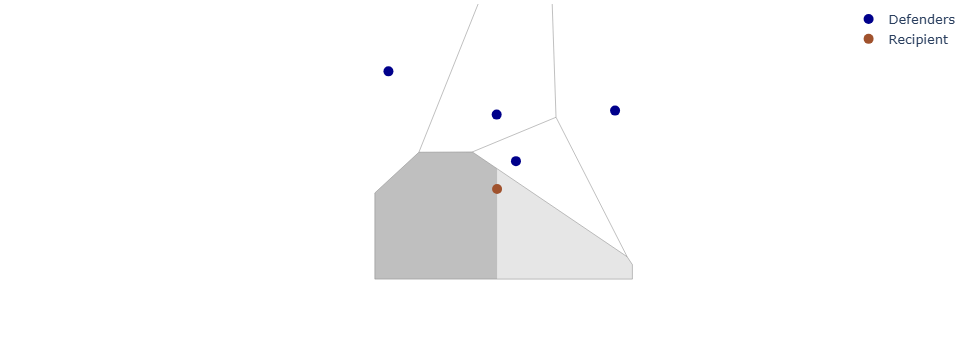

19985.0
23 17 26


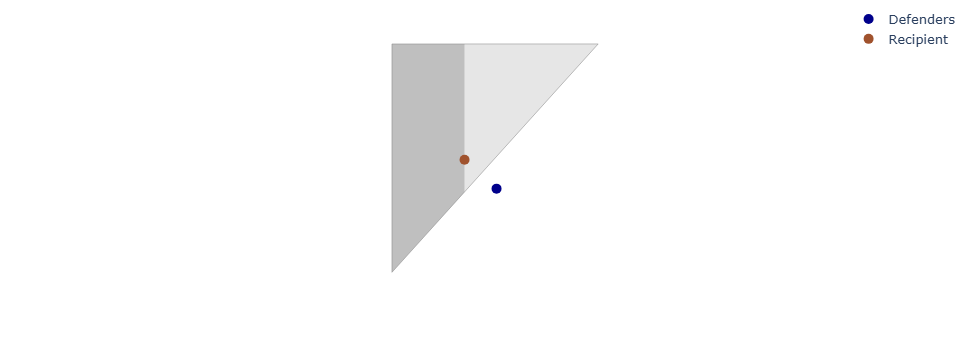

20875.0
180 39 184


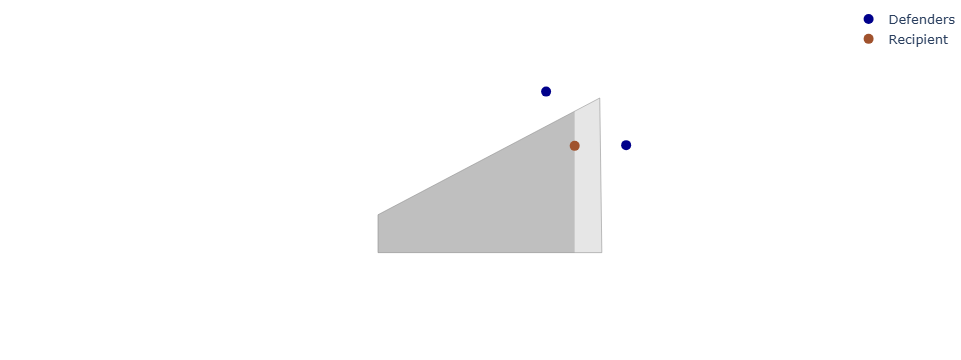

21507.0
164 36 167


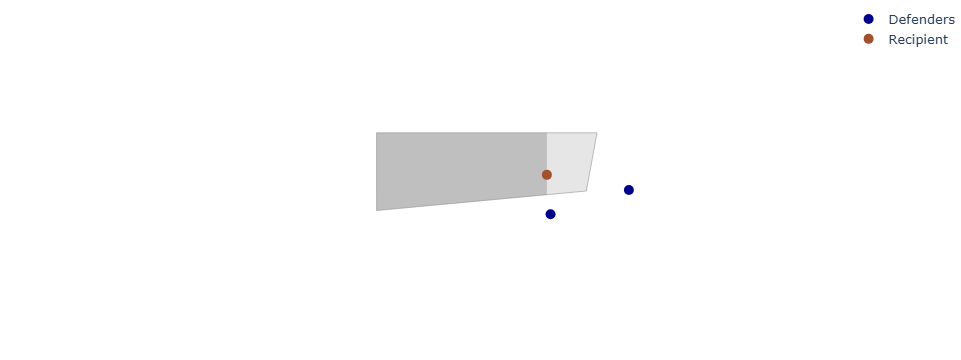

21850.0
25 26 28


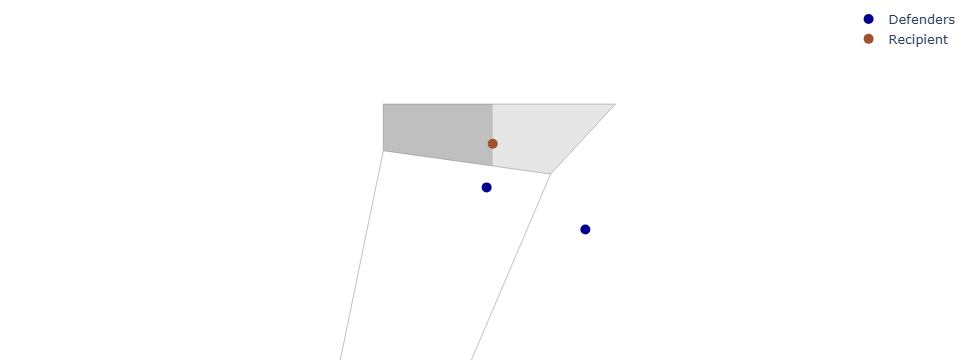

22062.0
27 75 31


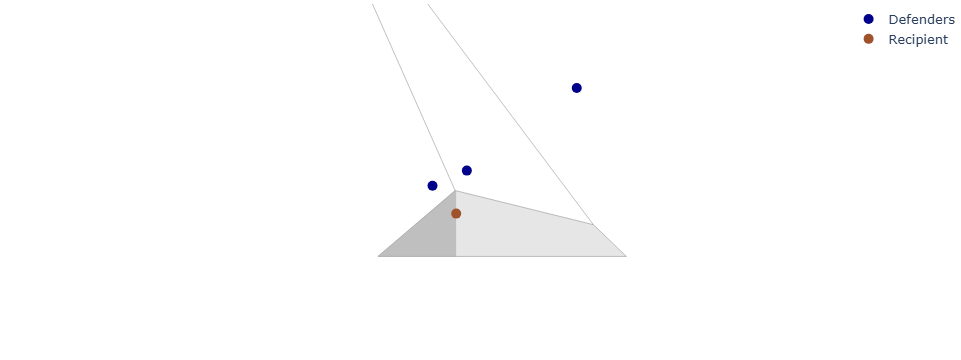

23402.0
14 32 17


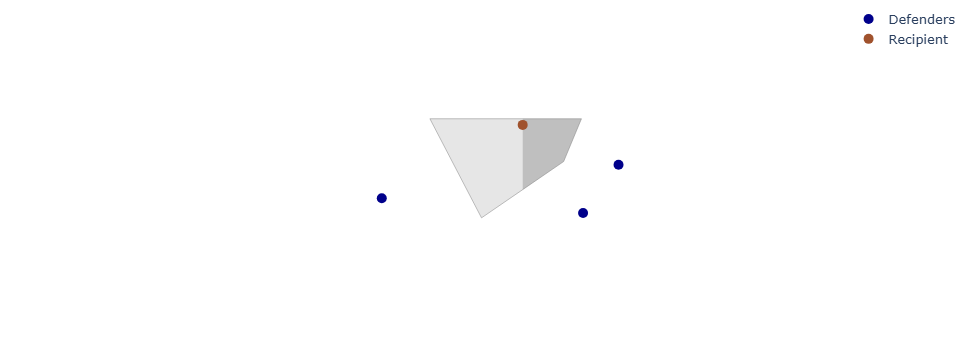

23412.0
12 0 12


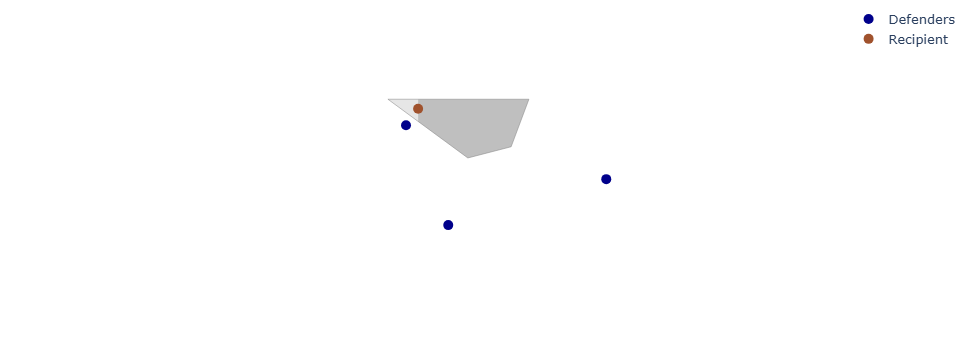

24775.0
75 47 79


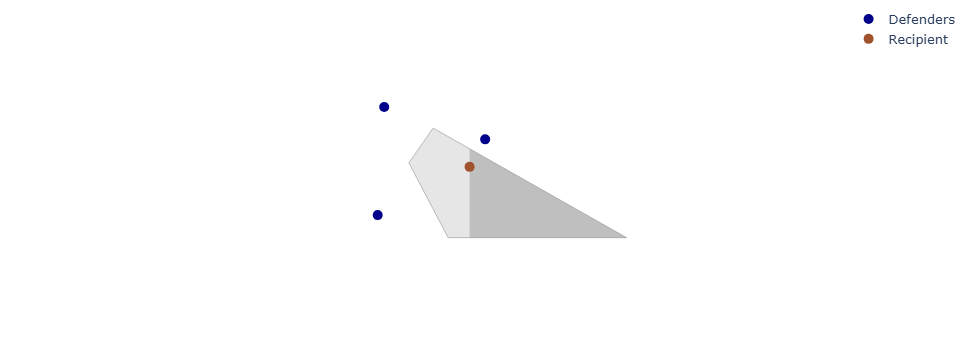

24925.0
45 34 49


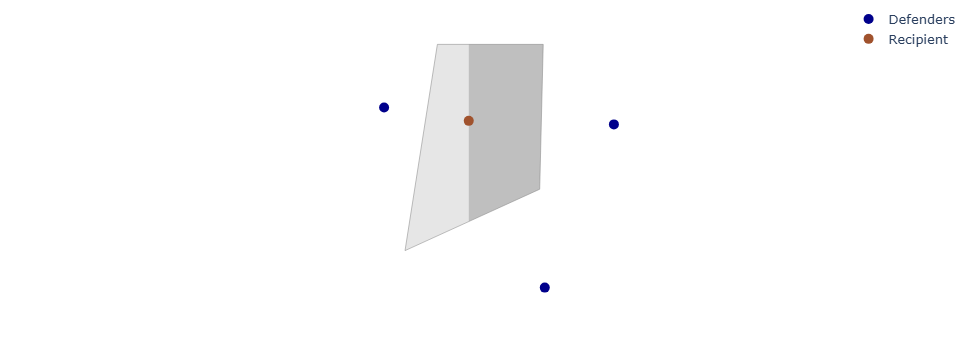

In [46]:
for idx, row in model_1_data[10:20].iterrows():
    frame = row['receive_frame']
    recipient_id = row['sk_recipient_id']
    frame_data = [f for f in data if f['frame'] == frame]
    frame_df = pd.DataFrame(frame_data)
    expanded_df = pd.concat(frame_df.apply(explode_data, axis=1).to_list(), ignore_index=True)
    expanded_df['team'] = expanded_df['player_id'].apply(lambda x: 'home' if x in home_p_ids else 'away' if x in away_p_ids else 'ball')
    recipient_team = expanded_df[expanded_df['player_id'] == recipient_id]['team'].item()
    ball_xy = row['ball_x_0'], row['ball_y_0']
    defending_df = expanded_df[~expanded_df['team'].isin([recipient_team, 'ball'])]
    defending_xy = defending_df[['x', 'y']].to_numpy()

    factor_x = 1 if ball_xy[0] > 0 else -1
    factor_y = 1 if ball_xy[1] > 0 else -1
    boundary_points = np.array(
        [[ball_xy[0], pitch_width/2*factor_y+(pitch_width/2*factor_y-ball_xy[1])], 
         [ball_xy[0], ball_xy[1] - 40*factor_y],
         [pitch_length/2*factor_x+(pitch_length/2*factor_x-ball_xy[0]), ball_xy[1]],
         [ball_xy[0] - 40, ball_xy[1]], 
         [ball_xy[0] + 40, ball_xy[1]]]) 
    points = np.vstack([ball_xy, defending_xy, boundary_points])
    points_nbs = get_neighbors(points, ball_xy)
    vertices = get_vertices(points_nbs, ball_xy)    
    
    area_forward, area_backward, points_forward, points_backward = get_areas(vertices, ball_xy, factor_x)
    SoF = area_forward + np.log(area_backward+1)

    # hull_points = np.array([p for i, p in enumerate(points_nbs) if 
    #           not np.any((p == boundary_points).all(axis = 1))])
    fig = plot_vor(points_nbs, hull_points, ball_xy, boundary_points, vertices, 
         points_backward, points_forward)
    print(frame)
    print(int(area_forward), int(area_backward), int(SoF))
    fig.show()    

In [17]:
SoF

259.49112108402267